**Predicting Investor-Owned Electric Utilities in the U.S.**

CST383 Data Science

Professor Ergezer

Jesus Martinez Miranda,

Jorge Vazquez,

Walid Elgammal,

Zuhra Totakhail

6/9/2025


# Introduction
The U.S. Electric Utility Companies and Rates: Look-up by Zip code (2020) includes average rates for each type of electricity by residential, commercial, and industrial categories. The dataset consists of a total of 9 columns and 28,027 rows, representing the available data as of 2020. The team aims to quantify the variation of rate in a hierarchical multivariable analysis. Some interpretation examples include answering questions such as whether specific ownership types tend to have lower rates in certain states or whether municipal utilities offer lower commercial electricity rates compared to other states, highlighting a competitive advantage and financial attractiveness. The team will work on a model that predict if an electric utility companies is owned by an investor.



# Project Objective
We aim to build a machine learning model to predict whether an electric utility company is investor-owned or not, using relevant numerical and categorical features from the dataset.

# Data Exploration

In [65]:
import numpy as np
import pandas as pd
from scipy.stats import zscore
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import graphviz
from sklearn.tree import export_graphviz
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score



# allow output to span multiple output lines in the console
pd.set_option('display.max_columns', 500)

# switch to seaborn default stylistic parameters
# see the useful https://seaborn.pydata.org/tutorial/aesthetics.html
sns.set()
sns.set_context('paper') # 'talk' for slightly larger

# change default plot size
rcParams['figure.figsize'] = 9,7


# Reading data and merging data sets

In [66]:
url1 = "https://raw.githubusercontent.com/jorgevaz47/CST383_DS_Project/working_walid/data/iou_zipcodes_2020.csv"
url2 = "https://raw.githubusercontent.com/jorgevaz47/CST383_DS_Project/working_walid/data/non_iou_zipcodes_2020.csv"

df1 = pd.read_csv(url1)
df2 = pd.read_csv(url2)

df = pd.concat([df1, df2], ignore_index=True)
print(df.shape)
df.info()
df.describe()

(80204, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80204 entries, 0 to 80203
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   zip           80204 non-null  int64  
 1   eiaid         80204 non-null  int64  
 2   utility_name  80204 non-null  object 
 3   state         80204 non-null  object 
 4   service_type  80204 non-null  object 
 5   ownership     80204 non-null  object 
 6   comm_rate     80204 non-null  float64
 7   ind_rate      80204 non-null  float64
 8   res_rate      80204 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 5.5+ MB


,zip,eiaid,comm_rate,ind_rate,res_rate
count,80204.000000,80204.000000,80204.000000,80204.000000,80204.000000
mean,46426.440863,13788.970912,0.098005,0.066949,0.115826
std,27920.227188,10680.719250,0.044314,0.044657,0.050052
min,501.000000,55.000000,0.000000,0.000000,0.000000
25%,21657.000000,6422.000000,0.078465,0.045736,0.097577
50%,44398.000000,13573.000000,0.098762,0.064780,0.115913
75%,67954.000000,17066.000000,0.118236,0.082462,0.135057
max,99950.000000,57483.000000,0.700000,0.650000,0.500285


# Dataset Description
The dataset is from data.gov and was compiled by the National Renewable Energy Laboratory (NREL) using data from ABB, the Velocity Suite, and the U.S. Energy Information Administration’s Form 861. It includes information about utility names, ownership type, residential/commercial rates, number of customers, and zip codes.



<table border="1" style="border-collapse: collapse; width: 100%;">
  <thead>
    <tr>
      <th style="padding: 8px; text-align: left;">Column Name</th>
      <th style="padding: 8px; text-align: left;">Description</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style="padding: 8px;">zip</td>
      <td style="padding: 8px;">5-digit ZIP code representing the geographic area of the utility service</td>
    </tr>
    <tr>
      <td style="padding: 8px;">eiaid</td>
      <td style="padding: 8px;">Unique identifier for the utility company from the Energy Information Administration (EIA)</td>
    </tr>
    <tr>
      <td style="padding: 8px;">utility_name</td>
      <td style="padding: 8px;">Name of the electric utility company serving the ZIP code</td>
    </tr>
    <tr>
      <td style="padding: 8px;">state</td>
      <td style="padding: 8px;">U.S. state abbreviation where the ZIP code and utility are located</td>
    </tr>
    <tr>
      <td style="padding: 8px;">service_type</td>
      <td style="padding: 8px;">Type of customer service: residential, commercial, or industrial</td>
    </tr>
    <tr>
      <td style="padding: 8px;">ownership</td>
      <td style="padding: 8px;">Ownership category of the utility, e.g., municipal, investor-owned, cooperative</td>
    </tr>
    <tr>
      <td style="padding: 8px;">comm_rate</td>
      <td style="padding: 8px;">Average commercial electricity rate charged by the utility (cents per kWh)</td>
    </tr>
    <tr>
      <td style="padding: 8px;">ind_rate</td>
      <td style="padding: 8px;">Average industrial electricity rate charged by the utility (cents per kWh)</td>
    </tr>
    <tr>
      <td style="padding: 8px;">res_rate</td>
      <td style="padding: 8px;">Average residential electricity rate charged by the utility (cents per kWh)</td>
    </tr>
  </tbody>
</table>


# Missing Data
We noticed that no data is missing from the sets.

In [67]:
print(df.isnull().sum())


zip             0
eiaid           0
utility_name    0
state           0
service_type    0
ownership       0
comm_rate       0
ind_rate        0
res_rate        0
dtype: int64


# Discovering the count of rows with all zero values

In [68]:
print("Zero values per column:")
print((df[['comm_rate', 'ind_rate', 'res_rate']] == 0).sum())
both_zero = ((df['ind_rate'] == 0) & (df['res_rate'] == 0)).sum()
print(f"Rows where both ind_rate and res_rate are zero: {both_zero}")

Zero values per column:
comm_rate     183
ind_rate     3387
res_rate     4841
dtype: int64
Rows where both ind_rate and res_rate are zero: 234


# what is the percentage of rows with zero values among the three rate columns

In [69]:
zero_rows = (df[['comm_rate', 'ind_rate', 'res_rate']] == 0).any(axis=1).sum()
total_rows = len(df)
percentage = 100 * zero_rows / total_rows
print(f"Rows with at least one zero: {zero_rows} ({percentage:.2f}%)")

Rows with at least one zero: 8100 (10.10%)


# Features Selection
The dataset was compiled from two sources, covering both investor-owned utilities (IOUs) and non-investor-owned utilities. According to the publisher, the National Renewable Energy Laboratory (NREL), the files include average rates for each utility—not average rates per ZIP code. The combined dataset contains 80,204 rows and 9 features.
There are three true numeric features: comm_rate, ind_rate, and res_rate (see Table 1-1). While the ZIP code is stored as a numeric value, it represents a categorical location code. Similarly, eiaid is an arbitrary identifier and does not carry meaningful magnitude or order.
For this project, we drop both eiaid and utility_name, as they do not provide meaningful predictive information. Instead, we focus on comm_rate, ind_rate, res_rate, and service_type as predictors. These selected features are complete and contain no missing values. Additionally, we exclude ZIP codes due to their complexity and limited predictive value in Machine Learning model.

README Updated

# Data Preprocessing

In [70]:
df.drop(columns=["zip", "eiaid", "utility_name"], inplace=True)

In [71]:
indices = np.where((df["comm_rate"] == 0) | (df["ind_rate"] == 0) | (df["res_rate"] == 0))[0]
mask = np.isin(df.index, indices)
print(f"Percent of data dropped due to entry of 0: {((df[mask].shape[0] / df.shape[0])*100):.2f}%")

Percent of data dropped due to entry of 0: 10.10%


We have taken a note that some of the data entries contain 0 as their value for one of the rates. We are not certain, but this likely means that the provider did not provide for that specific client group such as industry, residential, or commercial. After some preprocessing, it was noted that we would lose about 10% of our data set if we dropped all the rows that contain a 0 in either of those fields. For now, we will be dropping them since our dataset is still very large. We can reintroduce them if we note some issues with our dataset, but we will have to introduce a way to handle the 0 values

# Drop all rows where any of the three rate columns is zero

In [72]:
df = df[~(df[['comm_rate', 'ind_rate', 'res_rate']] == 0).any(axis=1)]
print(f"Remaining rows: {len(df)}")

Remaining rows: 72104


In [73]:
df = pd.get_dummies(df, columns=["service_type"])
df.head()

,state,ownership,comm_rate,ind_rate,res_rate,service_type_Bundled,service_type_Delivery
1,AL,Investor Owned,0.121895,0.063652,0.135057,True,False
2,AL,Investor Owned,0.121895,0.063652,0.135057,True,False
3,AL,Investor Owned,0.121895,0.063652,0.135057,True,False
4,AL,Investor Owned,0.121895,0.063652,0.135057,True,False
5,AL,Investor Owned,0.121895,0.063652,0.135057,True,False


Given that we are aiming to predict whether a utility is invester owned or not, we also need to split the service_type column into separate columns utilizing the one-hot encoding method where each unique value in the original column creates new columns. Here there is only one values that will be True in a given row for the created dummy columns. In this case they are "service_type_Bundled", "service_type_Delivery", and "service_type_Energy"

# Data  Visualization

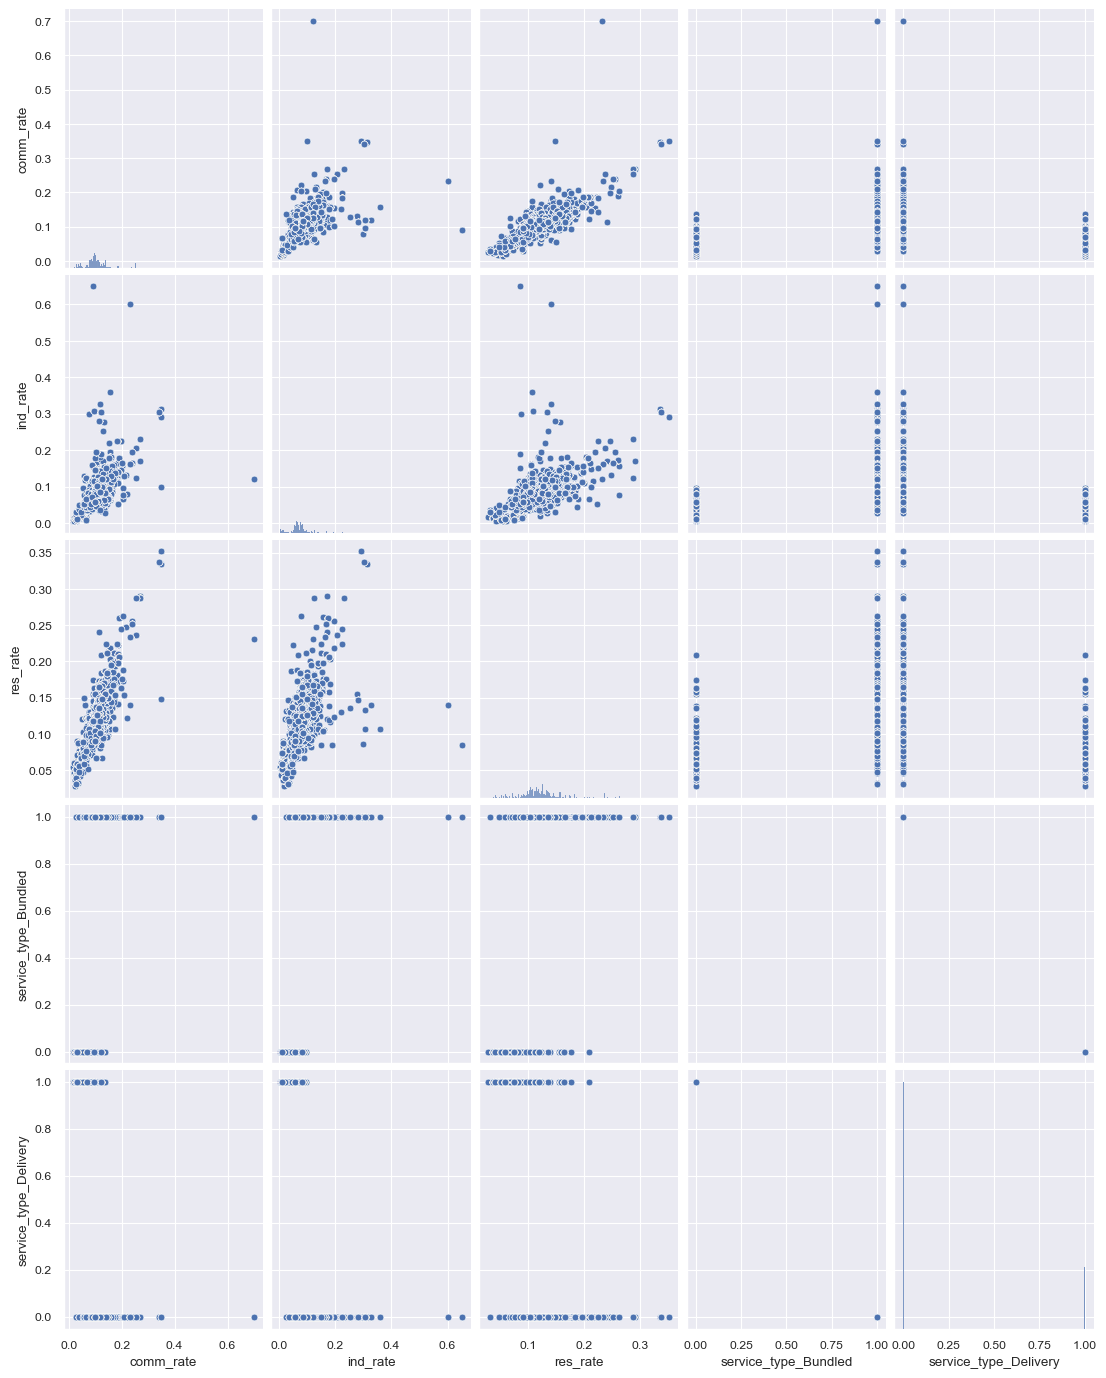

In [74]:
sns.pairplot(data=df, kind='scatter', height=2.8, aspect=0.8)

In [75]:
print(df.columns)

Index(['state', 'ownership', 'comm_rate', 'ind_rate', 'res_rate',
       'service_type_Bundled', 'service_type_Delivery'],
      dtype='object')


Text(0.5, 0, 'Service Type')

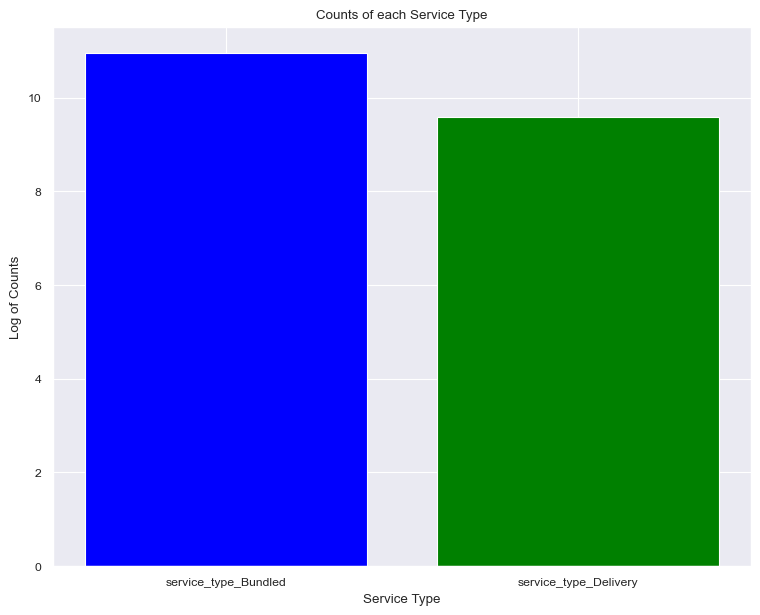

In [76]:
# "service_type_energy" was removed from bar plot due to being dropped during preprocessing zeroing (causing error)
service_counts = df[["service_type_Bundled", "service_type_Delivery"]].sum()
plt.bar(service_counts.index, np.log(service_counts.values), color=["blue", "green"])
plt.title("Counts of each Service Type")
plt.ylabel("Log of Counts")
plt.xlabel("Service Type")

Here are two visualizations of the data for now. One shows a pairpolot of all the numerical categories in the df to easily inspect for any relationships. We have also plotted a log bar plot to see the amount of each service type relative to each other.

# Machine Learning Data Preparation

In [77]:
# Select the predictor variables and target variables to be used 
predictors = ["service_type_Bundled", "service_type_Delivery", "comm_rate", "ind_rate", "res_rate"]
target = "ownership"
X = df[predictors].values
y = df[target].values

In [78]:
# KNN can be slow, so get a random sample of the full data set
indexes = np.random.choice(y.size, size=10000, replace=False)
X_mini = X[indexes]
y_mini = y[indexes]

In [79]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_mini, y_mini, test_size=0.30, random_state=42)

For now, the predictor varibales are grouped together. A side not that we may need to split the 